In [10]:
import json

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [11]:
# Generate simulated data
!uv run src/sim_data_generator_optimized.py simulated_data/parameters.json

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 2500, 'n_genes': 3000, 'n_tfs': 200, 'ground_truth_activation_prob': 0.08, 'ground_truth_inactivation_prob': 0.08, 'include_tfs_in_expression': False, 'min_num_of_targets_per_tf': 3, 'max_num_of_targets_per_tf': 20, 'standard_deviation_shift': 0.5, 'missing_percentage': 70, 'random_seed': 20, 'distribution_type': 'negative_binomial'}
Generating prior data...
Generating gene expression data...
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv


Cells, Genes:(2500, 3000) and 1% Cells: 25
Wrote simulated_data/simulated_scRNASeq_data_stats.tsv


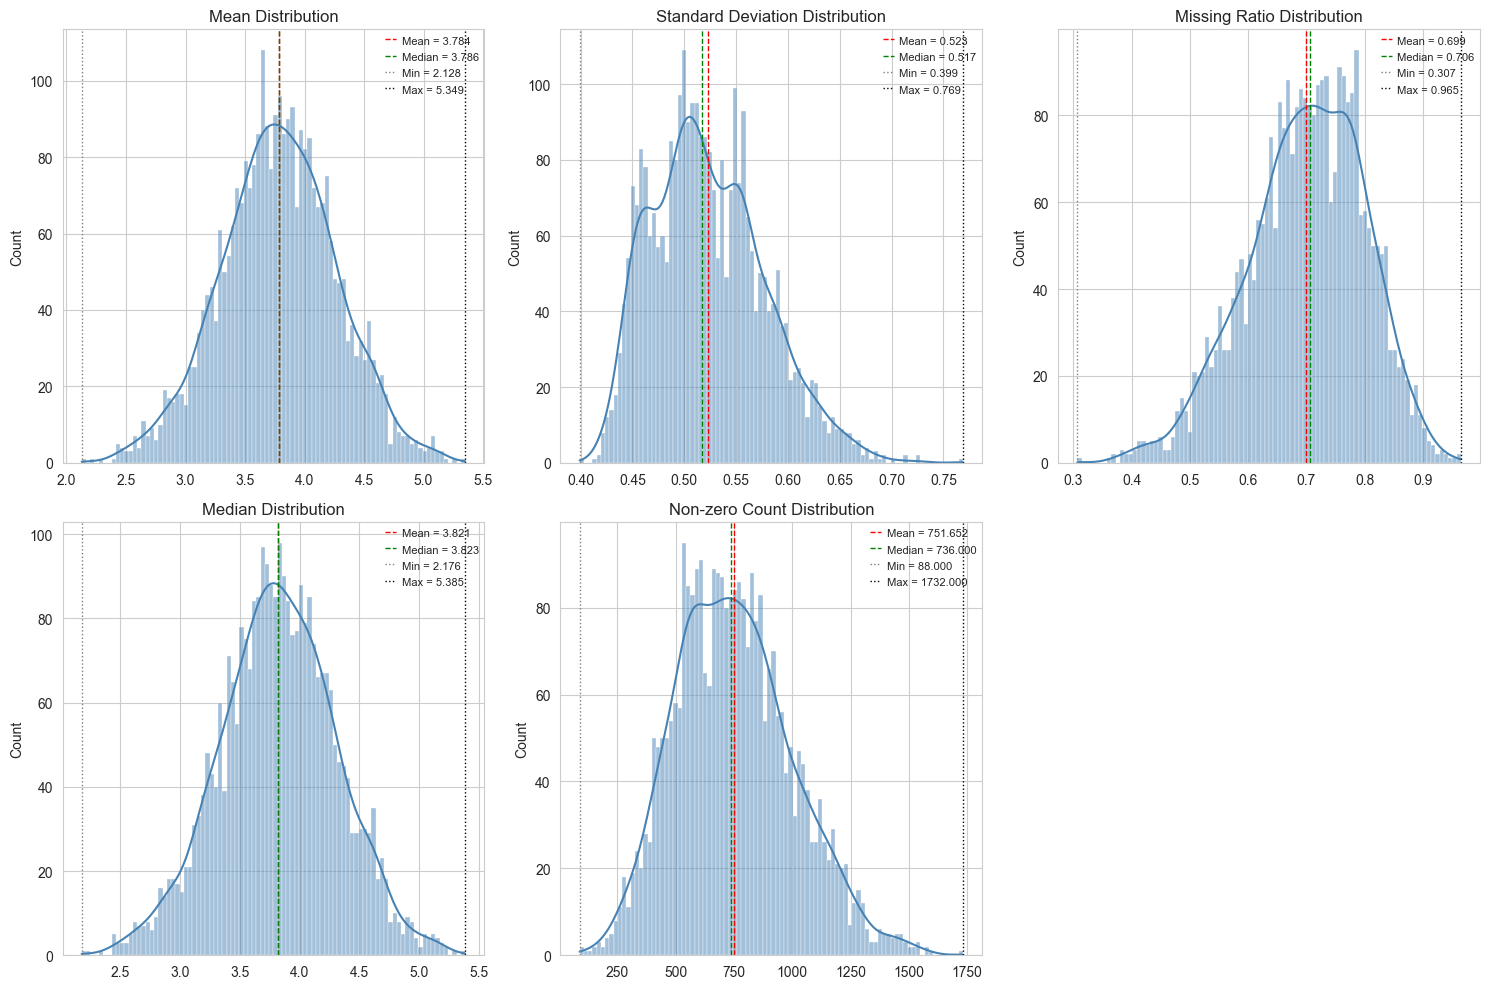

In [12]:
# Plot stats of data
def plot_hist_with_stats(data, ax, title, bins=90, color='steelblue'):
    sns.histplot(data, bins=bins, ax=ax, color=color, kde=True)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    mean_val = np.mean(data)
    median_val = np.median(data)
    min_val = np.min(data)
    max_val = np.max(data)

    # Draw vertical lines
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean = {mean_val:.3f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median = {median_val:.3f}')
    ax.axvline(min_val, color='gray', linestyle=':', linewidth=1, label=f'Min = {min_val:.3f}')
    ax.axvline(max_val, color='black', linestyle=':', linewidth=1, label=f'Max = {max_val:.3f}')

    ax.legend(fontsize=8)


# Calculate stats
!uv run src/calculate_stat.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_scRNASeq_data_stats.tsv


stat_file = "simulated_data/simulated_scRNASeq_data_stats.tsv"
stat_df = pd.read_csv(stat_file, sep="\t", index_col=0)

# Some of the genes have all zero values. So the plot looks weird.
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_hist_with_stats(stat_df['mean_log'], axs[0, 0], 'Mean Distribution')
plot_hist_with_stats(stat_df['std_log'], axs[0, 1], 'Standard Deviation Distribution')
plot_hist_with_stats(stat_df['missing_ratio'], axs[0, 2], 'Missing Ratio Distribution')
plot_hist_with_stats(stat_df['median_log'], axs[1, 0], 'Median Distribution')
plot_hist_with_stats(stat_df['n_nonzero'], axs[1, 1], 'Non-zero Count Distribution')

# Remove the last empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

In [13]:
# Run kale
!uv run src/kale.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_prior_data.tsv simulated_data/_kale_scores.tsv

Not Weighted method selected; converting all weights to 1 or -1.
Using raw gene expression as input for per-cell ranking...
-> Using UNWEIGHTED mean rank calculation.
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|███████| 2500/2500 [00:01<00:00, 1503.94it/s]
[Parallel(n_jobs=8)]: Done 2296 out of 2500 | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 2500 out of 2500 | elapsed:    2.2s finished

Aggregating results...
kale completed


In [14]:
# Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"

gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)
adata

AnnData object with n_obs × n_vars = 2500 × 3000

In [15]:
# Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"

effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}

net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

net.head()

,source,target,weight
0,TF_1,G_1814,1
1,TF_1,G_2414,1
2,TF_1,G_1546,1
3,TF_1,G_2362,1
4,TF_1,G_2097,1


In [16]:
# Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"

ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

print(f"Ground truths shape: {ground_truths.shape}")
print(ground_truths.head(10))

Ground truths shape: (500000, 2)
        Cell_TF  Value
0   Cell_1_TF_1      0
1   Cell_2_TF_1      0
2   Cell_3_TF_1      0
3   Cell_4_TF_1      0
4   Cell_5_TF_1      0
5   Cell_6_TF_1      0
6   Cell_7_TF_1      0
7   Cell_8_TF_1      0
8   Cell_9_TF_1      0
9  Cell_10_TF_1      0


In [17]:
methods_to_run = ["viper", "mlm"]
dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

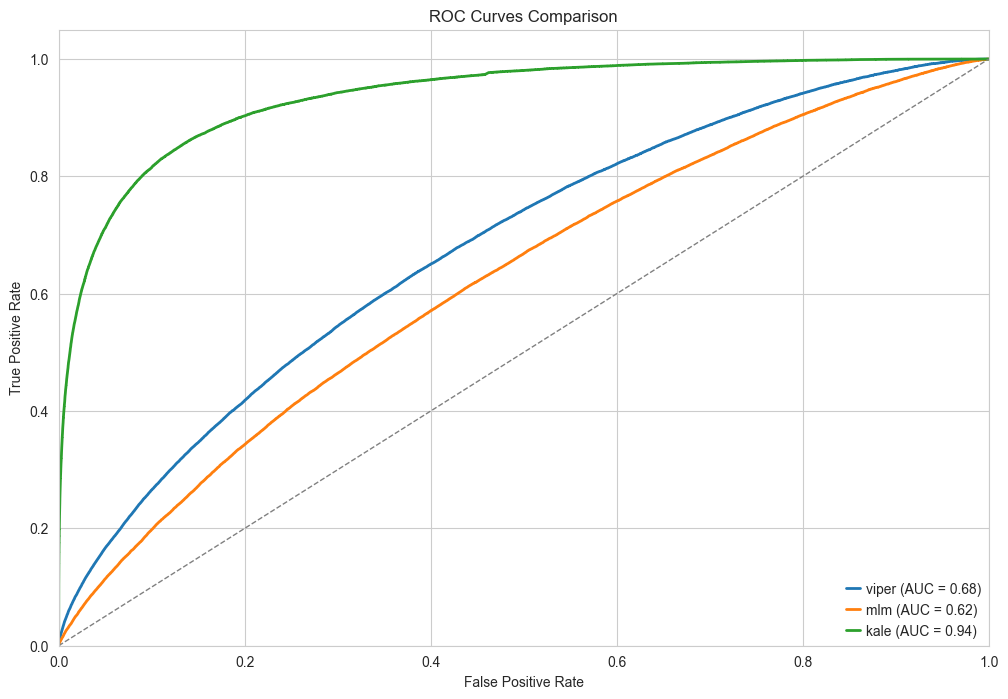

In [18]:
plt.figure(figsize=(12, 8))

methods_to_run.append("kale")

for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)

    else:
        # Get the scores for the current method
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{method} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

In [61]:
# ## Understanding Negative Binomial Distribution (Gamma-Poisson Mixture)
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# n_cells = 5
# n_genes = 6
#
# rng = np.random.default_rng(42)
#
# gene_prop = rng.lognormal(mean=0.0, sigma=1.0, size=n_genes)
# print(gene_prop)
#
# gene_prop_normalized = gene_prop / gene_prop.sum()  # Normalize to sum to 1
# print(gene_prop_normalized)

In [62]:
# # Plot gene_prop list as histogram
# gene_prop_plot = rng.lognormal(mean=0.0, sigma=1, size=10000)
# # gene_prop_plot = gene_prop_plot / gene_prop_plot.sum()
#
# plt.figure(figsize=(8, 6))
# sns.histplot(gene_prop_plot, bins=50, kde=True, color='skyblue')
# plt.title('Histogram of Gene Proportions')
# plt.xlabel('Gene Proportion')
# plt.ylabel('Frequency')
# plt.show()

In [63]:
# target_libsize = 1.0e4
# libsize = rng.lognormal(mean=np.log(target_libsize), sigma=0.35, size=n_cells)
# libsize

In [64]:
# mean_mat = np.outer(libsize, gene_prop_normalized)  # shape (n_cells, n_genes)
# mean_mat

In [65]:
# theta = 5.0  # dispersion parameter
# gamma_shape = theta
# gamma_scale = mean_mat / theta
# rate = rng.gamma(shape=5, scale=gamma_scale)  # same shape as mean_mat
# rate

In [66]:
# counts = rng.poisson(lam=rate)
# counts

## parameters.json test suite

In [19]:
final_result = []

test_suite = [
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 5,
        "max_num_of_targets_per_tf": 30,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 42,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 5,
        "max_num_of_targets_per_tf": 30,
        "standard_deviation_shift": 2.0,
        "missing_percentage": 60,
        "random_seed": 1,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 5,
        "max_num_of_targets_per_tf": 30,
        "standard_deviation_shift": 0.25,
        "missing_percentage": 80,
        "random_seed": 7,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 42,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 50,
        "max_num_of_targets_per_tf": 300,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 1337,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 99,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 11,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 10000,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 12,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 1000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 21,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.2,
        "ground_truth_inactivation_prob": 0.2,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 22,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.05,
        "ground_truth_inactivation_prob": 0.05,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 23,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 42,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 2.0,
        "missing_percentage": 20,
        "random_seed": 1,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.05,
        "ground_truth_inactivation_prob": 0.05,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 20,
        "max_num_of_targets_per_tf": 150,
        "standard_deviation_shift": 0.25,
        "missing_percentage": 80,
        "random_seed": 2,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.2,
        "ground_truth_inactivation_prob": 0.2,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 50,
        "max_num_of_targets_per_tf": 200,
        "standard_deviation_shift": 1.0,
        "missing_percentage": 40,
        "random_seed": 3,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 500,
        "n_genes": 1000,
        "n_tfs": 100,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 5,
        "max_num_of_targets_per_tf": 50,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 4,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 10000,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": True,
        "min_num_of_targets_per_tf": 20,
        "max_num_of_targets_per_tf": 150,
        "standard_deviation_shift": 1.0,
        "missing_percentage": 50,
        "random_seed": 5,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.15,
        "ground_truth_inactivation_prob": 0.15,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 100,
        "max_num_of_targets_per_tf": 300,
        "standard_deviation_shift": 4.0,
        "missing_percentage": 30,
        "random_seed": 6,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 8,
        "max_num_of_targets_per_tf": 40,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 90,
        "random_seed": 7,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.2,
        "ground_truth_inactivation_prob": 0.05,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 15,
        "max_num_of_targets_per_tf": 80,
        "standard_deviation_shift": 1.0,
        "missing_percentage": 60,
        "random_seed": 8,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 50,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 50,
        "max_num_of_targets_per_tf": 200,
        "standard_deviation_shift": 2.0,
        "missing_percentage": 40,
        "random_seed": 9,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 500,
        "ground_truth_activation_prob": 0.08,
        "ground_truth_inactivation_prob": 0.08,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 50,
        "max_num_of_targets_per_tf": 200,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 70,
        "random_seed": 10,
        "distribution_type": "normal"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "standard_deviation_shift": 2.0,
        "missing_percentage": 20,
        "random_seed": 11,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.05,
        "ground_truth_inactivation_prob": 0.05,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 2,
        "max_num_of_targets_per_tf": 150,
        "standard_deviation_shift": 0.25,
        "missing_percentage": 80,
        "random_seed": 12,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.2,
        "ground_truth_inactivation_prob": 0.2,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 50,
        "max_num_of_targets_per_tf": 200,
        "standard_deviation_shift": 1.0,
        "missing_percentage": 40,
        "random_seed": 13,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 500,
        "n_genes": 1000,
        "n_tfs": 100,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 5,
        "max_num_of_targets_per_tf": 50,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 60,
        "random_seed": 14,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 10000,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": True,
        "min_num_of_targets_per_tf": 20,
        "max_num_of_targets_per_tf": 150,
        "standard_deviation_shift": 1.0,
        "missing_percentage": 50,
        "random_seed": 15,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.15,
        "ground_truth_inactivation_prob": 0.15,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 100,
        "max_num_of_targets_per_tf": 300,
        "standard_deviation_shift": 4.0,
        "missing_percentage": 30,
        "random_seed": 16,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 8,
        "max_num_of_targets_per_tf": 40,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 90,
        "random_seed": 17,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_activation_prob": 0.2,
        "ground_truth_inactivation_prob": 0.05,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 15,
        "max_num_of_targets_per_tf": 80,
        "standard_deviation_shift": 1.0,
        "missing_percentage": 60,
        "random_seed": 18,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 50,
        "ground_truth_activation_prob": 0.1,
        "ground_truth_inactivation_prob": 0.1,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 50,
        "max_num_of_targets_per_tf": 200,
        "standard_deviation_shift": 2.0,
        "missing_percentage": 40,
        "random_seed": 19,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 500,
        "ground_truth_activation_prob": 0.08,
        "ground_truth_inactivation_prob": 0.08,
        "include_tfs_in_expression": False,
        "min_num_of_targets_per_tf": 3,
        "max_num_of_targets_per_tf": 20,
        "standard_deviation_shift": 0.5,
        "missing_percentage": 70,
        "random_seed": 20,
        "distribution_type": "negative_binomial"
    }
]

for i, test_case in enumerate(test_suite):
    with open("simulated_data/parameters.json", "w") as f:
        json.dump(test_case, f, indent=4)


    # Generate simulated data
    !uv run src/sim_data_generator_optimized.py simulated_data/parameters.json


    # Run Updated kale
    !uv run src/kale.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_prior_data.tsv simulated_data/_kale_scores.tsv


    # Gene Expression data
    gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
    gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
    adata = sc.AnnData(gene_exp)

    # Prior Knowledge Network
    net_file = "simulated_data/simulated_prior_data.tsv"
    effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
    net = pd.read_csv(
        net_file,
        sep="\t",
        names=["source", "weight", "target"],
        usecols=[0, 1, 2],
        converters={"weight": effect_map.get}
    )[["source", "target", "weight"]]

    # Ground Truths
    ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
    ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
    ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
    ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
    ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
    ground_truths = ground_truths[["Cell_TF", "Value"]]

    # Run other methods
    methods_to_run = ["viper", "mlm"]
    dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

    methods_to_run.append("kale")
    for method in methods_to_run:
        if method == "kale":
            method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
        else:
            method_scores = adata.obsm[f"score_{method}"]

        # Melt the DataFrame to long format
        scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
        scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
        scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
        scores_out = scores_out[["Cell_TF", "Value"]]

        # Merge with ground truths
        scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

        # Sort by Cell_TF to ensure consistent ordering
        scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
        scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
        roc_auc = auc(fpr, tpr)

        # collect AUC results
        test_case["auc_" + method] = roc_auc

    final_result.append(test_case)

# Save final results to a CSV file
final_result_df = pd.DataFrame(final_result)
final_result_df.drop(['output_dir', 'output_exp_file', 'output_prior_file', 'output_ground_truth_file'], axis=1,
                     inplace=True)
final_result_df.to_csv("simulated_data/simulation_test_suite_results_log.csv", index=False)

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 2500, 'n_genes': 3000, 'n_tfs': 200, 'ground_truth_activation_prob': 0.1, 'ground_truth_inactivation_prob': 0.1, 'include_tfs_in_expression': False, 'min_num_of_targets_per_tf': 5, 'max_num_of_targets_per_tf': 30, 'standard_deviation_shift': 0.5, 'missing_percentage': 60, 'random_seed': 42, 'distribution_type': 'negative_binomial'}
Generating prior data...
Generating gene expression data...
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv
Not Weighted method selected; converting all weights to 1 or -1.
Using raw gene expression as input for per-cell ranking...
-> Using UNWEIGHTED mean rank calculation.
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in 

In [20]:
final_result_df

,n_cells,n_genes,n_tfs,ground_truth_activation_prob,ground_truth_inactivation_prob,include_tfs_in_expression,min_num_of_targets_per_tf,max_num_of_targets_per_tf,standard_deviation_shift,missing_percentage,random_seed,distribution_type,auc_viper,auc_mlm,auc_kale
0,2500,3000,200,0.10,0.10,False,5,30,0.50,60,42,negative_binomial,0.778999,0.699800,0.977908
1,2500,3000,200,0.10,0.10,False,5,30,2.00,60,1,negative_binomial,0.973163,0.963598,0.924914
2,2500,3000,200,0.10,0.10,False,5,30,0.25,80,7,negative_binomial,0.576126,0.548269,0.788422
3,2500,3000,200,0.10,0.10,False,10,100,0.50,60,42,negative_binomial,0.859597,0.815367,0.992627
4,2500,3000,200,0.10,0.10,False,50,300,0.50,60,1337,negative_binomial,0.882485,0.936696,0.997526
5,2500,3000,200,0.10,0.10,False,10,100,0.50,60,99,negative_binomial,0.863447,0.819710,0.993442
6,500,3000,200,0.10,0.10,False,10,100,0.50,60,11,negative_binomial,0.858653,0.815859,0.992090
7,10000,3000,200,0.10,0.10,False,10,100,0.50,60,12,negative_binomial,0.855893,0.812572,0.991985
8,2500,1000,200,0.10,0.10,False,10,100,0.50,60,21,negative_binomial,0.789167,0.762512,0.961852
9,2500,3000,200,0.20,0.20,False,10,100,0.50,60,22,negative_binomial,0.840621,0.833596,0.983398


In [15]:
final_result_df

,n_cells,n_genes,n_tfs,ground_truth_activation_prob,ground_truth_inactivation_prob,include_tfs_in_expression,min_num_of_targets_per_tf,max_num_of_targets_per_tf,standard_deviation_shift,missing_percentage,random_seed,distribution_type,auc_viper,auc_mlm,auc_kale
0,2500,3000,200,0.10,0.10,False,5,30,0.50,60,42,negative_binomial,0.778999,0.871941,0.977908
1,2500,3000,200,0.10,0.10,False,5,30,2.00,60,1,negative_binomial,0.973163,0.959026,0.924914
2,2500,3000,200,0.10,0.10,False,5,30,0.25,80,7,negative_binomial,0.576126,0.653939,0.788422
3,2500,3000,200,0.10,0.10,False,10,100,0.50,60,42,negative_binomial,0.859597,0.952420,0.992627
4,2500,3000,200,0.10,0.10,False,50,300,0.50,60,1337,negative_binomial,0.882485,0.977860,0.997526
5,2500,3000,200,0.10,0.10,False,10,100,0.50,60,99,negative_binomial,0.863447,0.955581,0.993442
6,500,3000,200,0.10,0.10,False,10,100,0.50,60,11,negative_binomial,0.858653,0.951503,0.992090
7,10000,3000,200,0.10,0.10,False,10,100,0.50,60,12,negative_binomial,0.855893,0.954167,0.991985
8,2500,1000,200,0.10,0.10,False,10,100,0.50,60,21,negative_binomial,0.789167,0.885200,0.961852
9,2500,3000,200,0.20,0.20,False,10,100,0.50,60,22,negative_binomial,0.840621,0.940297,0.983398


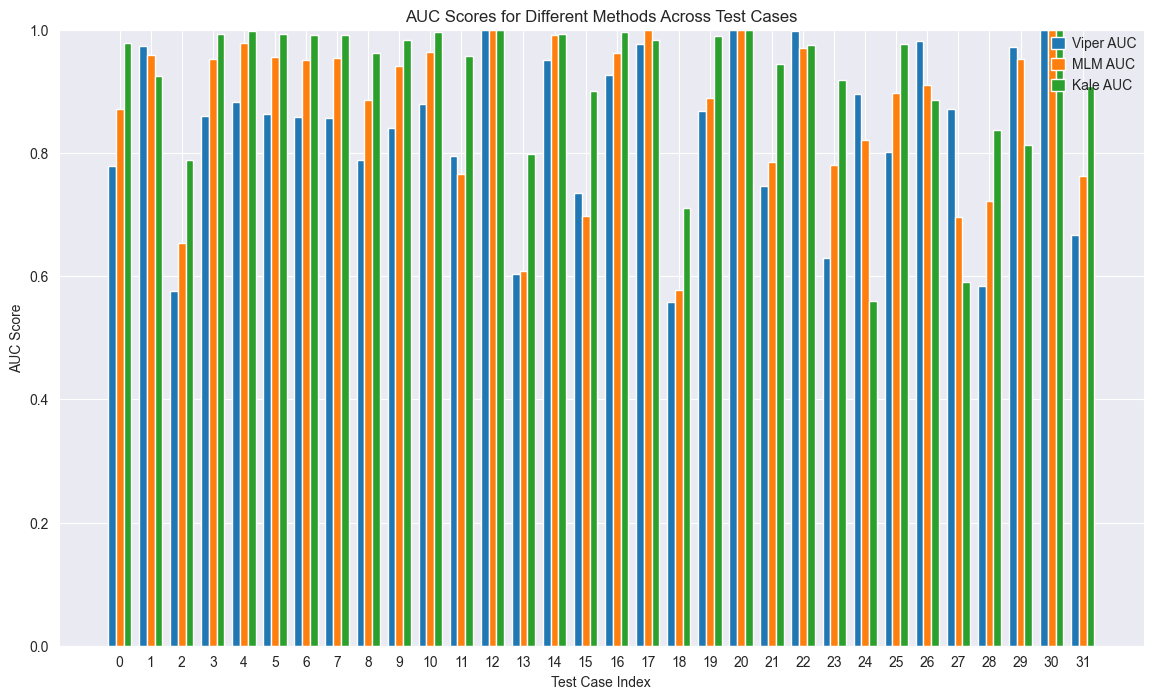

In [16]:
# Plot auc_viper, auc_mlm, auc_kale for each test case
plt.figure(figsize=(14, 8))
x = np.arange(len(final_result_df))
width = 0.25
plt.bar(x - width, final_result_df['auc_viper'], width, label='Viper AUC')
plt.bar(x, final_result_df['auc_mlm'], width, label='MLM AUC')
plt.bar(x + width, final_result_df['auc_kale'], width, label='Kale AUC')
plt.xlabel('Test Case Index')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Methods Across Test Cases')
plt.xticks(x)
plt.ylim(0, 1)
plt.legend()
plt.show()


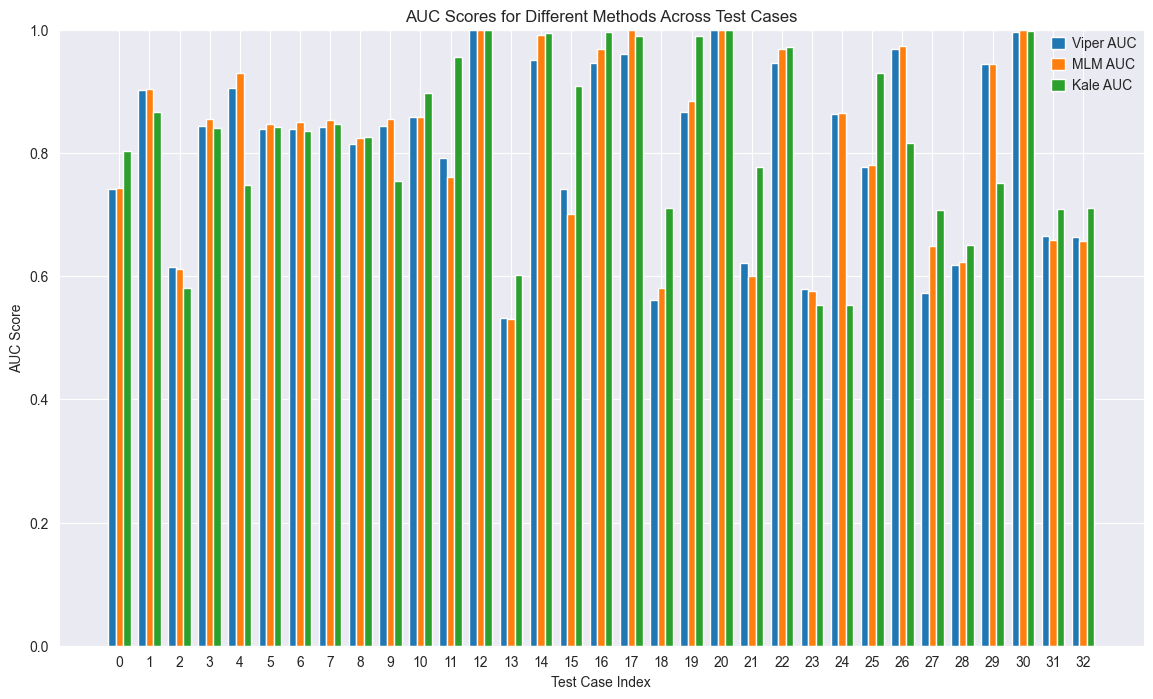

In [17]:
final_result_df = pd.read_csv("simulated_data/simulation_test_suite_results.csv", sep=",", index_col=0)

# Plot auc_viper, auc_mlm, auc_kale for each test case
plt.figure(figsize=(14, 8))
x = np.arange(len(final_result_df))
width = 0.25
plt.bar(x - width, final_result_df['auc_viper'], width, label='Viper AUC')
plt.bar(x, final_result_df['auc_mlm'], width, label='MLM AUC')
plt.bar(x + width, final_result_df['auc_kale'], width, label='Kale AUC')
plt.xlabel('Test Case Index')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Methods Across Test Cases')
plt.xticks(x)
plt.ylim(0, 1)
plt.legend()
plt.show()